# Loading Data


In [2]:
from TCR_TOOLS.classes.tcr import *
from TCR_TOOLS.core.io import write_pdb
from TCR_TOOLS.core.ops import *
# 1) Construct a TCR Data object from a PDB
tcr = TCR(
    input_pdb="/mnt/larry/lilian/DATA/Cory_data/6OVN/6OVN.pdb",
    traj_path=None,         # or an XTC/DCD if you have one
    contact_cutoff=5.0,
    min_contacts=50,
    legacy_anarci=True
)
# 2) See the paired receptors that were found
print(f"Found {len(tcr.pairs)} pair(s).")
pv = tcr.pairs[0]   # TCRPairView for first pair
#Information about the TCR is stored in the TCRPairView object
print(pv)
#to get sequences of the domains:
print(pv.cdr_fr_sequences())

QALSIQEGENATMNCSYKTSINNLQWYRQNSGRGLVHLILIRSNEREKHSGRLRVTLDTSKKSSSLLITASRAADTASYFCATAAVGGFKTIFGAGTRLFVKANIQNPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKCVLDMRSMDFKSNSAVAWSNKSDFACANAFNNSIIPEDTFFPSP
[info] Numbering chain A with length 194
DTEVTQTPKHLVMGMTNKKSLKCEQHMGHRAMYWYKQKAKKPPELMFVYSYEKLSINESVPSRFSPESPNSSLLNLHLHALQPEDSALYLCASSPLGREGLNTEAFFGQGTRLTVVEDLNKVFPPEVAVFEPSEAEISHTQKATLVCLATGFYPDHVELSWWVNGKEVHSGVCTDPQPLKEQPALNDSRYALSSRLRVSATFWQNPRNHFRCQVQFYGLSENDEWTQDRAKPVTQIVSAEAWGRAD
[info] Numbering chain B with length 246
Matched TCR pair: A-B | None
Found 1 pair(s).
TCRPairView(index=1, alpha_chain_id='A', beta_chain_id='B', alpha_type='A', beta_type='B', full_structure=<Structure id=pair1_subset>, chain_map={'alpha': 'A', 'beta': 'B'}, alpha_germline={'v_gene': [('human', 'TRAV17*01'), 0.9021739130434783], 'j_gene': [('human', 'TRAJ9*01'), 1.0]}, beta_germline={'v_gene': [('human', 'TRBV4-1*01'), 0.9789473684210527], 'j_gene': [('human', 'TRBJ1-1*01'), 1.0]}, _cached_traj_view=None)
{'A_

In [ ]:
#TO get full IMGT_renumbered and cleaned structture:
full_tcr=pv.full_structure
write_pdb("/workspaces/Graphormer/TCR_Metrics/full_tcr.pdb",full_tcr) #use a full path
#To automatically select only the variable fragment:
variable_fragment=pv.variable_structure
write_pdb("/workspaces/Graphormer/TCR_Metrics/variable_fragment.pdb",variable_fragment) #use a full path
#To get an scfv like structure (linker between the two chains)

#To get specific domain subsets:
A_CDR1_2_3=pv.domain_subset(region_names=["A_CDR1","A_CDR2","A_CDR3"], atom_names={"CA","C","N"}, include_het=False) #regions include IMGT definition of CDRs and FRs, also A_variable, B_variable
#if you want all atoms, just leave atom_names as None, if you want to include heteroatoms, set include_het to True
write_pdb("/workspaces/Graphormer/TCR_Metrics/A_CDR1_2_3.pdb",A_CDR1_2_3) #use a full path

#to get atom indexes in the structure of your selection use domain_idx instead of domain_subset

linked_structure=pv.linked_structure(linker_sequence="GGGGS"*3)
write_pdb("/workspaces/Graphormer/TCR_Metrics/linked_structure.pdb",linked_structure) #use a full path
#Please note, that while Modeller is used to add the linker, the structure is not altered, aside from the added linker. It may however be translated rigidly slightly. The domains stay intact though and their orientation is not altered!


✅ Saved linked structure to /tmp/tcr_link_f6w79sku/tcr_variable_sanitized_output.pdb
✅ Saved renumbered PDB to: /tmp/tcr_link_f6w79sku/tcr_variable_sanitized_output.pdb
✅ Written alignment file to: /tmp/tcr_link_f6w79sku/linked_variable_imgt.ali
✅ Chain ID detected: A
✅ Sequence length: 234 residues
runcmd_____W>: creation of new member 'linker_pos_start' in <Model containing 0 chains, 0 residues, and 0 atoms>: possible typo!
runcmd_____W>: creation of new member 'linker_pos_end' in <Model containing 0 chains, 0 residues, and 0 atoms>: possible typo!
readlinef__W> File: /tmp/tcr_link_f6w79sku/tcr_variable_sanitized_output_consec_no_linker.pdb, Line: 3432
              Modeller will only read the first 80 characters of this line.


check_ali___> Checking the sequence-structure alignment. 

Implied intrachain target CA(i)-CA(i+1) distances longer than  8.0 angstroms:

ALN_POS  TMPL  RID1  RID2  NAM1  NAM2     DIST
----------------------------------------------
END OF TABLE
read_to_681_> 

## Aligning Structures

In [ ]:
import Bio.PDB
import numpy
from TCR_TOOLS.aligners.aligning import *
#Aligning Structures based on selected regions
tcr1 = TCR(
    input_pdb="/mnt/larry/lilian/DATA/Cory_data/6OVN/6OVN.pdb",
    traj_path=None,         # or an XTC/DCD if you have one
    contact_cutoff=5.0,
    min_contacts=50,
    legacy_anarci=True
)
pv1=tcr1.pairs[0]
tcr2 = TCR(
    input_pdb="/mnt/larry/lilian/DATA/Cory_data/4UDT/4UDT.pdb",
    traj_path=None,         # or an XTC/DCD if you have one
    contact_cutoff=5.0,
    min_contacts=50,
    legacy_anarci=True
)
pv2=tcr2.pairs[0]

ref_model = pv1.full_structure
write_pdb("/workspaces/Graphormer/TCR_Metrics/ref_model.pdb",ref_model) #use a full path
alt_model = pv2.full_structure

def tm_align_different_tcrs(ref_tcr_pair, mov_tcr_pair, region_names, inplace=False):
    mov_full_structure=mov_tcr_pair.full_structure
    ref_subset = ref_tcr_pair.domain_subset(region_names=region_names, atom_names={"CA"})
    alt_subset = mov_tcr_pair.domain_subset(region_names=region_names, atom_names={"CA"})
    ref_atoms=ref_tcr_pair.domain_idx(region_names=region_names, atom_names={"CA"})
    alt_atoms=mov_tcr_pair.domain_idx(region_names=region_names, atom_names={"CA"})
    with tempfile.TemporaryDirectory() as td:
        mov_pdb = os.path.join(td, "mov.pdb")
        ref_pdb = os.path.join(td, "ref.pdb")
        # The write_pdb function saves the subset structures.
        write_pdb(mov_pdb, alt_subset)
        write_pdb(ref_pdb, ref_subset)
        # 3. Run TM-align on the new, clean PDBs.
        out = run_tmalign(mov_pdb, ref_pdb, tmalign_bin="TMalign")

    # 4. Parse the alignment. The pairs (i, j) are 0-based indices
    pairs = parse_tmalign_map(out, len_mov=len([i for i in alt_subset.get_atoms()]), len_ref=len([i for i in ref_subset.get_atoms()]))

    mapped_idx_mov = [alt_atoms[i] for (i, j) in pairs]
    mapped_idx_ref = [ref_atoms[j] for (i, j) in pairs]

    # Now, your mapped indices will be correct.
    print("Mapped indices (mov):", mapped_idx_mov)
    print("Mapped indices (ref):", mapped_idx_ref)

    #Align these paired atom lists:
    super_imposer = Bio.PDB.Superimposer()
    atom_list_ref=[atom for i,atom in enumerate(ref_subset.get_atoms()) if atom.get_serial_number()-1 in mapped_idx_ref]
    atom_list_mov=[atom for i,atom in enumerate(alt_subset.get_atoms()) if atom.get_serial_number()-1 in mapped_idx_mov]
    super_imposer.set_atoms(atom_list_ref, atom_list_mov)

    print( "Alignment RMSD (avergage over all aligned atoms in specified region): ",numpy.abs(super_imposer.rms))
    #Update the structure by moving all the atoms in
    #this model (not just the ones used for the alignment)
    if inplace:
        super_imposer.apply(mov_tcr_pair.full_structure.get_atoms())
        return mov_tcr_pair.full_structure
    else:
        moved_structure_copy = mov_tcr_pair.full_structure.copy()
        # Apply the transformation to the atoms of the copy
        super_imposer.apply(moved_structure_copy.get_atoms())
        # Return the transformed copy, leaving the original untouched
        return moved_structure_copy

write_pdb("/workspaces/Graphormer/TCR_Metrics/aligned_alt_model.pdb",alt_model) #use a full path


QALSIQEGENATMNCSYKTSINNLQWYRQNSGRGLVHLILIRSNEREKHSGRLRVTLDTSKKSSSLLITASRAADTASYFCATAAVGGFKTIFGAGTRLFVKANIQNPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKCVLDMRSMDFKSNSAVAWSNKSDFACANAFNNSIIPEDTFFPSP
[info] Numbering chain A with length 194
DTEVTQTPKHLVMGMTNKKSLKCEQHMGHRAMYWYKQKAKKPPELMFVYSYEKLSINESVPSRFSPESPNSSLLNLHLHALQPEDSALYLCASSPLGREGLNTEAFFGQGTRLTVVEDLNKVFPPEVAVFEPSEAEISHTQKATLVCLATGFYPDHVELSWWVNGKEVHSGVCTDPQPLKEQPALNDSRYALSSRLRVSATFWQNPRNHFRCQVQFYGLSENDEWTQDRAKPVTQIVSAEAWGRAD
[info] Numbering chain B with length 246
Matched TCR pair: A-B | None
GIQVEQSPPDLILQEGANSTLRCNFSDSVNNLQWFHQNPWGQLINLFYIPSGTKQNGRLSATTVATERYSLLYISSSQTTDSGVYFCAVDSATSGTYKYIFGTGTRLKVLANIQNPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKCVLDMRSMDFKSNSAVAWSNKSDFACANAFNNSIIPEDTFFPSP
[info] Numbering chain A with length 202
TGVSQNPRHKITKRGQNVTFRCDPISEHNRLYWYRQTLGQGPEFLTYFQNEAQLEKSRLLSDRFSAERPKGSFSTLEIQRTEQGDSAMYLCASSLGGYEQYFGPGTRLTVTEDLKNVFPPEVAVFVPSEAEISHTQKATLVCLATGFYPDHVELSWWVNGKEVHSGVCTDPQPLKEQPALNDSRYALSSRLRVSATFWQDPRN

In [ ]:
from TCR_TOOLS.aligners.aligning import align_traj_to_refstructure
from TCR_TOOLS.core import io
from TCR_TOOLS.scoring.rmsd_tm import rmsd_tm

tcr2 = TCR(
    input_pdb="/mnt/larry/lilian/DATA/Cory_data/6OVN/6OVN.pdb",
    traj_path="/mnt/larry/lilian/DATA/Cory_data/6OVN/6OVN_Prod.xtc",         # or an XTC/DCD if you have one
    contact_cutoff=5.0,
    min_contacts=50,
    legacy_anarci=True
)
pv_ref = tcr2.pairs[0]


traj_aligned, rmsd=pv_ref.traj.align_to_ref(pv_ref,
                     region_names=["A_variable"],
                     atom_names={"CA"},
                     inplace=False)

(n, k, rmsd_A, tm)=rmsd_tm(traj_aligned, pv_ref, regions=["A_variable"], atoms={"CA"})

QALSIQEGENATMNCSYKTSINNLQWYRQNSGRGLVHLILIRSNEREKHSGRLRVTLDTSKKSSSLLITASRAADTASYFCATAAVGGFKTIFGAGTRLFVKANIQNPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKCVLDMRSMDFKSNSAVAWSNKSDFACANAFNNSIIPEDTFFPSP
[info] Numbering chain A with length 194
DTEVTQTPKHLVMGMTNKKSLKCEQHMGHRAMYWYKQKAKKPPELMFVYSYEKLSINESVPSRFSPESPNSSLLNLHLHALQPEDSALYLCASSPLGREGLNTEAFFGQGTRLTVVEDLNKVFPPEVAVFEPSEAEISHTQKATLVCLATGFYPDHVELSWWVNGKEVHSGVCTDPQPLKEQPALNDSRYALSSRLRVSATFWQNPRNHFRCQVQFYGLSENDEWTQDRAKPVTQIVSAEAWGRAD
[info] Numbering chain B with length 246
Matched TCR pair: A-B | None


AttributeError: 'TrajectoryView' object has no attribute 'topology'

In [4]:
traj_aligned._traj.save_xtc(os.path.join(out_dir,"aligned.xtc"))

/workspaces/Graphormer/TCR_Metrics/TCR_TOOLS/scoring/PCA_projections.py:192: RuntimeWarning: divide by zero encountered in log
  fe = -kT * np.log(prob)


PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/Test_histogram_MD.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/Test_histogram_diffusion.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/Test_KDE_PMF_MD.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/Test_KDE_PMF_diffusion.npz
MSE (overlap only): 0.000
MSE (all space): 0.000


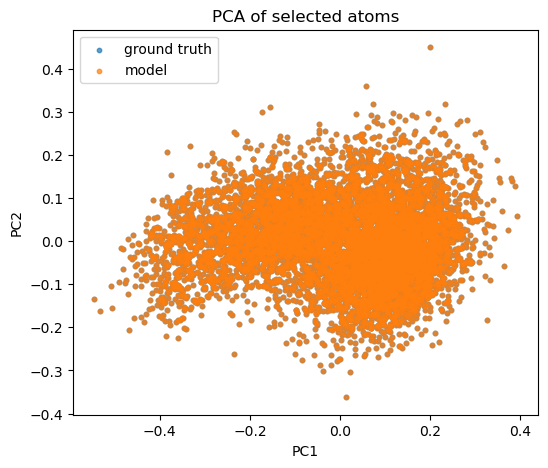

In [3]:
from TCR_TOOLS.scoring.PCA_projections import *
pca, proj_gt, proj_model=pca_project_two(
    traj_aligned,                    # TrajectoryView for ground truth
    traj_aligned,                   # TrajectoryView for computational traj
    region_names=["A_CDR3"],   # e.g., ["A_variable"] or ["A_CDR1","A_CDR2","A_CDR3"]
    atom_names={"CA"},
    n_components = 2,
    fit_on="gt")


outfolder="/workspaces/Graphormer/TCR_Metrics/test/plots"
name="Test"
plot_pca(proj_gt, proj_model, name, outfolder=outfolder)
temperature = 300
xbins, ybins = 50, 50
oriol_analysis(xbins, ybins, proj_gt, proj_model, temperature, name,outfolder=outfolder)


In [1]:
from TCR_TOOLS.classes.tcr import *
from TCR_TOOLS.core.io import write_pdb
from TCR_TOOLS.core.ops import *

gttcr = TCR(
    input_pdb="/mnt/larry/lilian/DATA/Cory_data/1KGC/1KGC.pdb",
    traj_path=None,         # or an XTC/DCD if you have one
    contact_cutoff=5.0,
    min_contacts=50,
    legacy_anarci=True
)
gttcr_pair=gttcr.pairs[0]
# 3) Get sequences (original vs IMGT, all chains)
print(get_sequence_dict(gttcr_pair.full_structure))
gttcr.attach_trajectory("/mnt/larry/lilian/DATA/Cory_data/1KGC/1KGC_Prod.xtc", topology_choice="imgt")


digtcr = TCR(
    input_pdb="/workspaces/Graphormer/TCR_Metrics/test/unlinked_dig.pdb",
    traj_path=None,         # or an XTC/DCD if you have one
    contact_cutoff=5.0,
    min_contacts=50,
    legacy_anarci=True
)
digtcr_pair = digtcr.pairs[0]

# If your XTC was written with CA/C/N only (or CA/C/N/O), specify exactly that:
digtcr_pair.attach_trajectory(
    "/workspaces/Graphormer/TCR_Metrics/test/unlinked_dig.xtc",
    region_names=None,                 # all residues
    atom_names={"CA","C","N"}          # add "O" if present in the XTC
)


KTTQPNSMESNEEEPVHLPCNHSTISGTDYIHWYRQLPSQGPEYVIHGLTSNVNNRMASLAIAEDRKSSTLILHRATLRDAAVYYCILPLAGGTSYGKLTFGQGTILTVHPNIQNPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKTVLDMRSMDFKSNSAVAWSNKSDFACANAFNNSIIPEDTFFPS
[info] Numbering chain A with length 201
GVSQSPRYKVAKRGQDVALRCDPISGHVSLFWYQQALGQGPEFLTYFQNEAQLDKSGLPSDRFFAERPEGSVSTLKIQRTQQEDSAVYLCASSLGQAYEQYFGPGTRLTVTEDLKNVFPPEVAVFEPSEAEISHTQKATLVCLATGFYPDHVELSWWVNGKEVHSGVSTDPQPLKEQPALNDSRYCLSSRLRVSATFWQNPRNHFRCQVQFYGLSENDEWTQDRAKPVTQIVSAEAWGRAD
[info] Numbering chain B with length 241
Matched TCR pair: A-B | None
{'A': 'KTTQPNSMESNEEEPVXLPXNXSTISGTDYIXWYRQLPSQGPEYVIXGLTSNVNNRMASLAIAEDRKSSTLILXRATLRDAAVYYXILPLAGGTSYGKLTFGQGTILTVXPNIQNPDPAVYQLRDSKSSDKSVXLFTDFDSQTNVSQSKDSDVYITDKTVLDMRSMDFKSNSAVAWSNKSDFAXANAFNNSIIPEDTFFPS', 'B': 'GVSQSPRYKVAKRGQDVALRXDPISGXVSLFWYQQALGQGPEFLTYFQNEAQLDKSGLPSDRFFAERPEGSVSTLKIQRTQQEDSAVYLXASSLGQAYEQYFGPGTRLTVTEDLKNVFPPEVAVFEPSEAEISXTQKATLVXLATGFYPDXVELSWWVNGKEVXSGVSTDPQPLKEQPALNDSRYCLSSRLRVSATFWQNPRNXFRXQVQFYGLSENDEWTQDRAKPV

In [2]:
from TCR_TOOLS.core import io
from TCR_TOOLS.scoring.rmsd_tm import rmsd_tm
from TCR_TOOLS.classes.tcr import *
from TCR_TOOLS.core.io import write_pdb
from TCR_TOOLS.core.ops import *

from TCR_TOOLS.scoring.PCA_methods import pca_project_two as pca_project

traj_aligned, rmsd=digtcr_pair.traj.align_to_ref(gttcr_pair,
                     region_names=["A_CDR3"],
                     atom_names={"CA","C","N"},
                     inplace=False)

gt_traj_aligned, rmsd=gttcr_pair.traj.align_to_ref(gttcr_pair,
                     region_names=["A_CDR3"],
                     atom_names={"CA","C","N"},
                     inplace=False)

(n, k, rmsd_A, tm)=rmsd_tm(traj_aligned, gttcr_pair, regions=["A_CDR3"], atoms={"CA"})

(n, k, rmsd_A, tm)=rmsd_tm(gt_traj_aligned, gttcr_pair, regions=["A_CDR3"], atoms={"CA"})



Frames scored: 500, mapped_pairs: 13
RMSD_A  mean=1.859  median=1.881  p95=2.087  max=2.242
TMscore mean=0.130  median=0.128  p95=0.165  min=0.078
Frames scored: 7055, mapped_pairs: 13
RMSD_A  mean=1.993  median=1.961  p95=2.645  max=3.355
TMscore mean=0.141  median=0.133  p95=0.224  min=0.049


## Normal COORD PCAs


In [3]:
#NORMAL COORD PCA
from TCR_TOOLS.scoring.PCA_projections import *
pca, proj_gt, proj_model,evr_gt, evr_pred=pca_project(
    gt_traj_aligned,                    # TrajectoryView for ground truth
    traj_aligned,                   # TrajectoryView for computational traj
    region_names=[ "A_CDR3"],   # e.g., ["A_variable"] or ["A_CDR1","A_CDR2","A_CDR3"]
    atom_names={"CA"},
    n_components = 2,
    fit_on="gt") #"concat_weighted"


outfolder="/workspaces/Graphormer/TCR_Metrics/test/plots/normal_pca"
name="1KGC"
plot_pca(proj_gt, proj_model, evr_gt, evr_pred, name, outfolder=outfolder)
temperature = 300
xbins, ybins = 50, 50
oriol_analysis(xbins, ybins, proj_gt, proj_model, temperature, name,outfolder=outfolder)

/workspaces/Graphormer/TCR_Metrics/TCR_TOOLS/scoring/PCA_projections.py:158: RuntimeWarning: divide by zero encountered in log
  fe = -kT * np.log(prob)


PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/normal_pca/1KGC_histogram_MD.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/normal_pca/1KGC_histogram_diffusion.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/normal_pca/1KGC_KDE_PMF_MD.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/normal_pca/1KGC_KDE_PMF_diffusion.npz
MSE (overlap only): 19.310
MSE (all space): 19.002


In [8]:
from TCR_TOOLS.scoring.embed_assesment import *

trust_results=trustworthiness_gt_pred(
    gt_traj_aligned,                    # TrajectoryView for ground truth
    traj_aligned,
    proj_gt,
    proj_model,
    region_names=["A_CDR3"],
    atom_names={"CA"},
    n_neighbors= 10)
print(trust_results)
mantel_results = mantel_rmsd_vs_embedding(
    gt_traj_aligned,
    traj_aligned,
    proj_gt,
    proj_model,
    region_names=[ "A_CDR3"],
    atom_names={"CA"},            # same selection you used for the distances
    method="spearman",
    permutations=9999,
    random_state=0,
    subsample_gt=500,            # optional speedups
    subsample_pred=500
)

print(mantel_results)

{'gt': np.float64(0.877897120878445), 'pred': np.float64(0.8534171310629515)}
{'gt': {'r': 0.8546845564028879, 'p': 0.0001}, 'pred': {'r': 0.6954060290512206, 'p': 0.0001}, 'combined': {'r': 0.8286154926361521, 'p': 0.0001}}


## CA_DISTANCE PCAs

In [5]:
from TCR_TOOLS.scoring.CA_distance_PCA import *
from TCR_TOOLS.scoring.PCA_projections import *
# Build GT/Pred distance embeddings on A_variable region, 2 PCs
model, Z_gt, Z_pred, info = distance_embedding(
    gt_traj_aligned,                    # TrajectoryView for ground truth
    traj_aligned,
    region_names=["A_CDR3"],
    reducer="kpca_cosine",          # 'pca'/ 'kpca_rbf' / 'kpca_cosine'
    n_components=2,
    standardize=True
)

outfolder="/workspaces/Graphormer/TCR_Metrics/test/plots/CA_distance_PCA"
#plot_pca(Z_gt, Z_pred, evr_gt=info["evr_gt"], evr_pred=info["evr_pred"], name="1KGC_CA_distance_PCA", outfolder=outfolder)
outfolder="/workspaces/Graphormer/TCR_Metrics/test/plots/CA_distance_kpca_cosine"
plot_pca(Z_gt, Z_pred, evr_gt=[0,0], evr_pred=[0,0], name="1KGC_CA_distance_PCA", outfolder=outfolder)



[1337, 1356, 1383, 1389, 1408, 1418, 1425, 1432, 1446, 1457, 1478, 1485, 1507, 1526]
[259, 262, 265, 268, 271, 274, 277, 280, 283, 286, 289, 292, 295, 298]


In [7]:
from TCR_TOOLS.scoring.embed_assesment import *

trust_results=trustworthiness_gt_pred(
    gt_traj_aligned,                    # TrajectoryView for ground truth
    traj_aligned,
    Z_gt,
    Z_pred,
    region_names=[ "A_CDR3"],
    atom_names={"CA"},
    n_neighbors= 10)
print(trust_results)
mantel_results = mantel_rmsd_vs_embedding(
    gt_traj_aligned,
    traj_aligned,
    Z_gt, Z_pred,
    region_names=[ "A_CDR3"],
    atom_names={"CA"},            # same selection you used for the distances
    method="spearman",
    permutations=9999,
    random_state=0,
    subsample_gt=500,            # optional speedups
    subsample_pred=500
)

print(mantel_results)

{'gt': np.float64(0.857517959430004), 'pred': np.float64(0.7934968008255934)}
{'gt': {'r': 0.7452081610460062, 'p': 0.0001}, 'pred': {'r': 0.7659544426607854, 'p': 0.0001}, 'combined': {'r': 0.7783431214138605, 'p': 0.0001}}


In [8]:
from TCR_TOOLS.scoring.embeddings import run_coords, run_ca_dist, run_dihedrals

# Dihedrals + dPCA (fit on GT)
for mode in ["pca", "kpca_rbf", "kpca_cosine", "kpca_poly","diffmap", "tica"]:
    Zg, Zp, info, tw, mt = run_dihedrals.run(
        gt_traj_aligned, traj_aligned,
        outdir=f"/workspaces/Graphormer/TCR_Metrics/test/test/dihed_{mode}",
        regions=["A_CDR3"],
        reducer=mode, fit_on="concat", dihedrals=("phi","psi"), encode="sincos",
        subsample=50
    )

# Coordinates + PCA (concat), EVR + metrics
for mode in ["pca", "kpca_rbf", "kpca_cosine", "kpca_poly","diffmap", "tica"]:
    Zg, Zp, info, tw, mt = run_coords.run(
        tv_gt=gt_traj_aligned, tv_pred=traj_aligned,
        outdir=f"/workspaces/Graphormer/TCR_Metrics/test/test/coords_{mode}",
        regions=["A_CDR3"],
        atoms=("CA","C","N"),
        reducer=mode, n_components=2, fit_on="concat", use_gt_scaler=True,
        subsample=50, mantel_method="spearman"
    )


# CA distances + kPCA (cosine)
for mode in ["pca", "kpca_rbf", "kpca_cosine", "kpca_poly","diffmap", "tica"]:
    Zg, Zp, info, tw, mt = run_ca_dist.run(
        gt_traj_aligned, traj_aligned,
        outdir=f"/workspaces/Graphormer/TCR_Metrics/test/test/ca_{mode}",
        regions=["A_CDR3"], fit_on="concat",
        reducer=mode, n_components=2, max_pairs=20000,
        subsample=50
    )




Features GT: (7055, 126), Pred: (500, 126)
Features GT: (7055, 126), Pred: (500, 126)
Features GT: (7055, 126), Pred: (500, 126)
Features GT: (7055, 126), Pred: (500, 126)
Features GT: (7055, 126), Pred: (500, 126)
Features GT: (7055, 126), Pred: (500, 126)


In [ ]:
from TCR_TOOLS.scoring.PCA_methods import pca_on_dihedrals

model, Z_gt, Z_pred, info = pca_on_dihedrals(
    gt_traj_aligned,
    traj_aligned,
    region_names=["A_CDR3", "A_CDR2", "A_CDR3"],
    dihedrals=("phi","psi"),
    encode="sincos",
    n_components=2,
    method="pca",
    fit_on="concat")

# For kPCA with RBF:
model_k, Z_gt_k, Z_pred_k, info_k = pca_on_dihedrals(
    gt_traj_aligned,
    traj_aligned,
    region_names=["A_CDR3", "A_CDR2", "A_CDR3"],
    dihedrals=("phi","psi"),
    method="kpca_rbf"          # gamma auto via median distance
)

In [ ]:
outfolder="/workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals"
name="1KGC"
plot_pca(Z_gt, Z_pred,  [100.0* i for i in info["evr_gt"]], [100.0* i for i in info["evr_pred"]], name, outfolder=outfolder)
temperature = 300
xbins, ybins = 50, 50
oriol_analysis(xbins, ybins, Z_gt, Z_pred, temperature, name,outfolder=outfolder)

/workspaces/Graphormer/TCR_Metrics/TCR_TOOLS/scoring/PCA_projections.py:158: RuntimeWarning: divide by zero encountered in log
  fe = -kT * np.log(prob)


PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals/1KGC_histogram_MD.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals/1KGC_histogram_diffusion.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals/1KGC_KDE_PMF_MD.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals/1KGC_KDE_PMF_diffusion.npz
MSE (overlap only): nan
MSE (all space): 14.644


In [ ]:
print(info_k)

{}


In [ ]:
outfolder="/workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals_kernel"
name="1KGC"
plot_pca(Z_gt_k, Z_pred_k,  [0,0], [0,0], name, outfolder=outfolder)
temperature = 300
xbins, ybins = 50, 50
oriol_analysis(xbins, ybins, Z_gt_k, Z_pred_k, temperature, name,outfolder=outfolder)

/workspaces/Graphormer/TCR_Metrics/TCR_TOOLS/scoring/PCA_projections.py:158: RuntimeWarning: divide by zero encountered in log
  fe = -kT * np.log(prob)


PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals_kernel/1KGC_histogram_MD.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals_kernel/1KGC_histogram_diffusion.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals_kernel/1KGC_KDE_PMF_MD.npz
PMF saved to /workspaces/Graphormer/TCR_Metrics/test/plots/dihedrals_kernel/1KGC_KDE_PMF_diffusion.npz
MSE (overlap only): nan
MSE (all space): 13.743


In [ ]:
trust_results=trustworthiness_gt_pred(
    gt_traj_aligned,                    # TrajectoryView for ground truth
    traj_aligned,
    proj_gt,
    proj_model,
    region_names=["A_CDR3", "A_CDR2", "A_CDR3"],
    atom_names={"CA"},
    n_neighbors= 10)
print(trust_results)

